# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
from sklearn.decomposition import PCA
sample_size = 10000
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 2
fuzzification_kernel_size = 16
enrich_lemmas_with_wn = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
# X_train, y_train, X_test, y_test = (
#     X_train[:sample_size],
#     y_train[:sample_size],
#     # X_train[:sample_size],
#     # y_train[:sample_size],
#     X_test[:sample_size],
#     y_test[:sample_size]
# )
# evaluating space on full, combined training+test set, as fuzzification model is nonparametric
X_test = pd.concat([X_train, X_test])
y_test = pd.concat([y_train, y_test])

sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel(
    dim_reduc=PCA(n_components=n_components)
)
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_test["sent_1"].to_list() + X_test["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.24045217,  0.07746743],
       [ 0.08702143, -0.12343179],
       [ 0.14292802,  0.23833844],
       ...,
       [-0.2637705 ,  0.13076067],
       [ 0.37495556, -0.08553485],
       [ 0.13288409, -0.1572941 ]], dtype=float32)

In [5]:
X_test = model.fit(X_test)
X_test = model.predict_batch(X_test, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate model

In [6]:
eval_harness.fit(X_test)
sims_df = eval_harness.get_similarities(X_test)
sims_df.head()


	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for baseline_sent approac

,fuzzy_baseline_sent_cos_sim,fuzzy_baseline_tok_cos_sim,fuzzy_intersection+intersection_cos_sim,fuzzy_intersection+mean_cos_sim,fuzzy_intersection+union_cos_sim,fuzzy_mean_cos_sim,fuzzy_selective_intersection+intersection+mean_cos_sim,fuzzy_selective_intersection+mean_cos_sim,fuzzy_selective_intersection+union_cos_sim,fuzzy_baseline_sent_wasserstein-1_sim,...,fuzzy_baseline_tok_quantum_sim,fuzzy_intersection+intersection_quantum_sim,fuzzy_intersection+mean_quantum_sim,fuzzy_intersection+union_quantum_sim,fuzzy_mean_quantum_sim,fuzzy_selective_intersection+intersection+mean_quantum_sim,fuzzy_selective_intersection+mean_quantum_sim,fuzzy_selective_intersection+union_quantum_sim,baseline_sent_cos_sim,baseline_tok_cos_sim
0,0.012899,0.016179,-0.002702,0.004383,-0.002702,-0.015578,0.002148,0.002148,0.002761,0.059348,...,0.000824,1.319299e-10,-0.010404,1.319299e-10,-0.001761,0.000092,0.000092,0.000014,0.257048,0.023789
1,-0.023979,0.000102,0.000838,-0.000189,0.000838,0.010746,-0.001076,-0.001076,0.019082,0.019921,...,0.001137,-4.035827e-11,0.013380,-4.035827e-11,-0.005739,-0.000033,-0.000033,-0.000033,-0.501311,0.010677
2,-0.045705,-0.261717,-0.049323,-0.003731,-0.049323,-0.029975,-0.015033,-0.015033,-0.074943,-0.234564,...,-0.100793,-4.470444e-07,-0.008213,-4.470444e-07,-0.010716,0.000079,0.000079,-0.000020,-0.659899,-0.231510
3,-0.007927,-0.065444,-0.006187,-0.006255,-0.006187,-0.004747,0.001844,0.001844,0.002465,-0.147570,...,-0.012386,1.478380e-10,0.013380,1.478380e-10,-0.000069,0.000063,0.000063,0.000019,-0.600718,-0.103648
4,0.009019,0.018428,-0.007291,-0.008389,-0.007291,0.008162,-0.001491,-0.001491,0.000603,0.121303,...,0.003334,1.477153e-10,-0.016828,1.477153e-10,0.001474,-0.000074,-0.000074,-0.250734,0.236747,0.028061


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

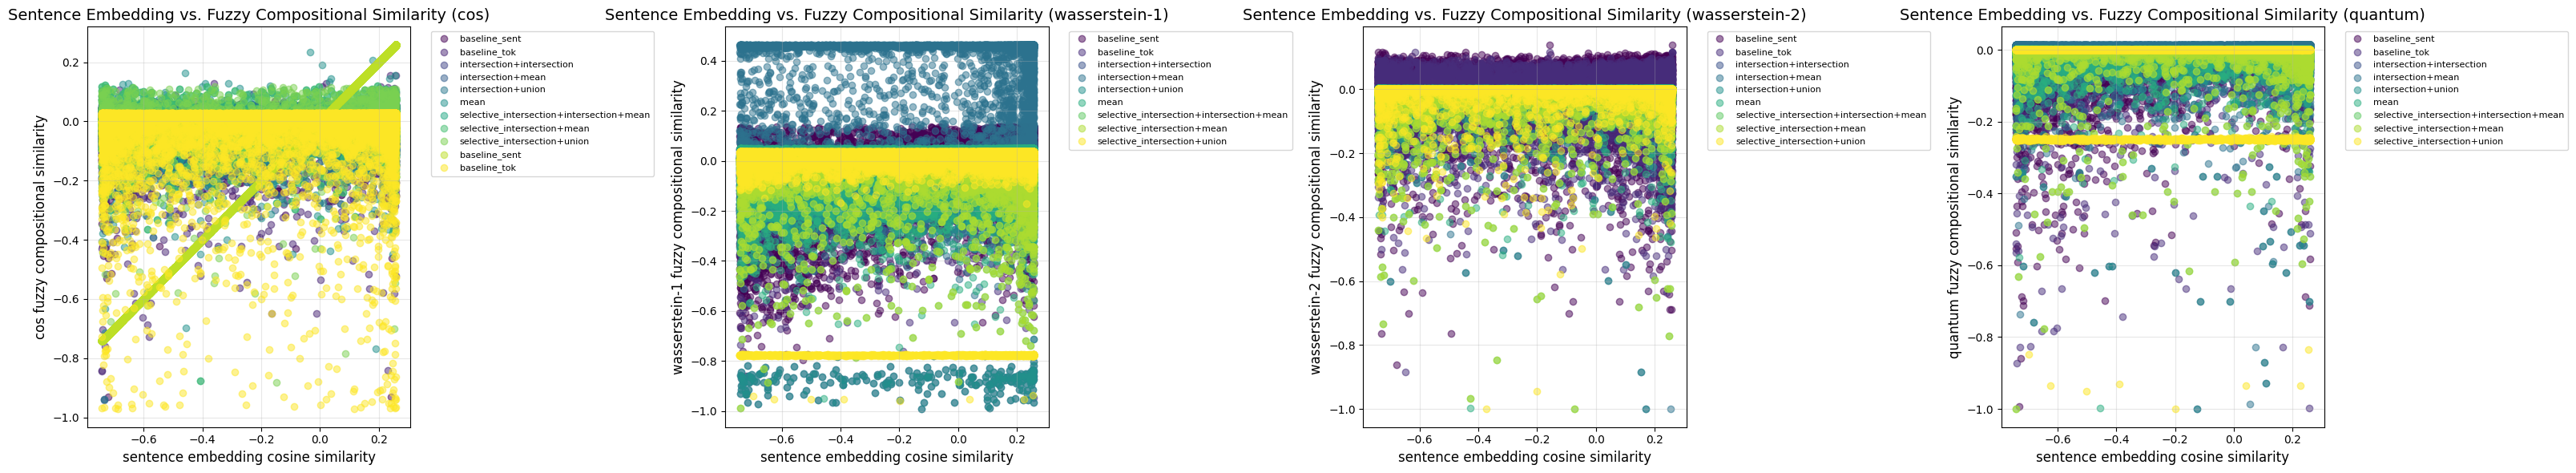

In [8]:
eval_harness.visualize_similarities(sims_df)

## Confusion Matrices

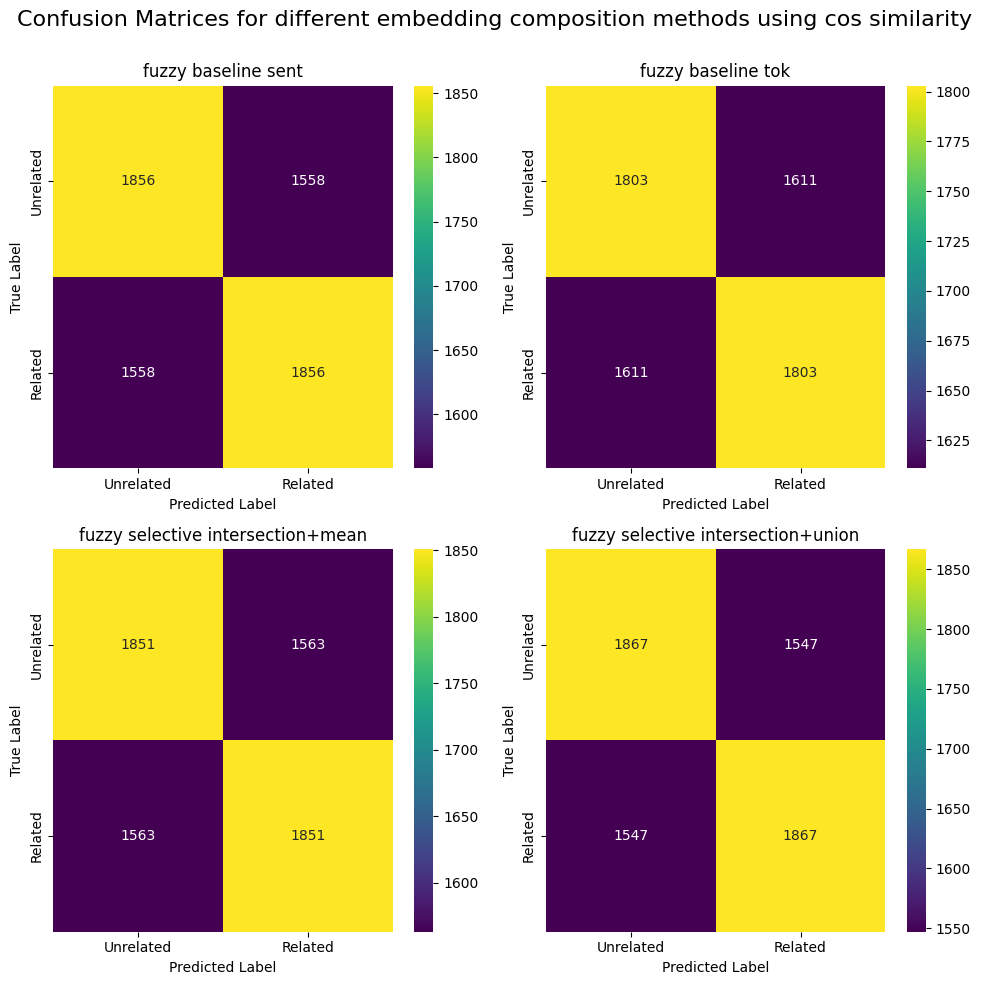

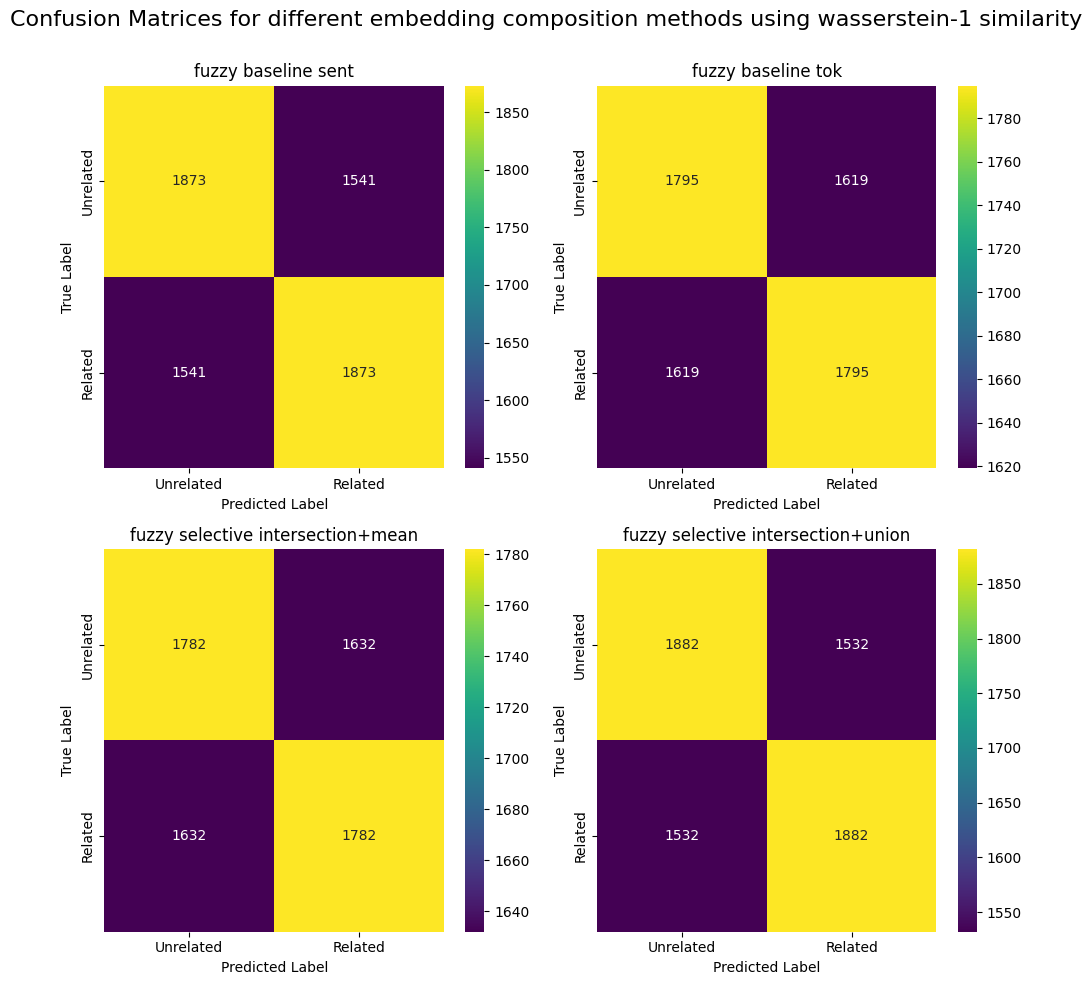

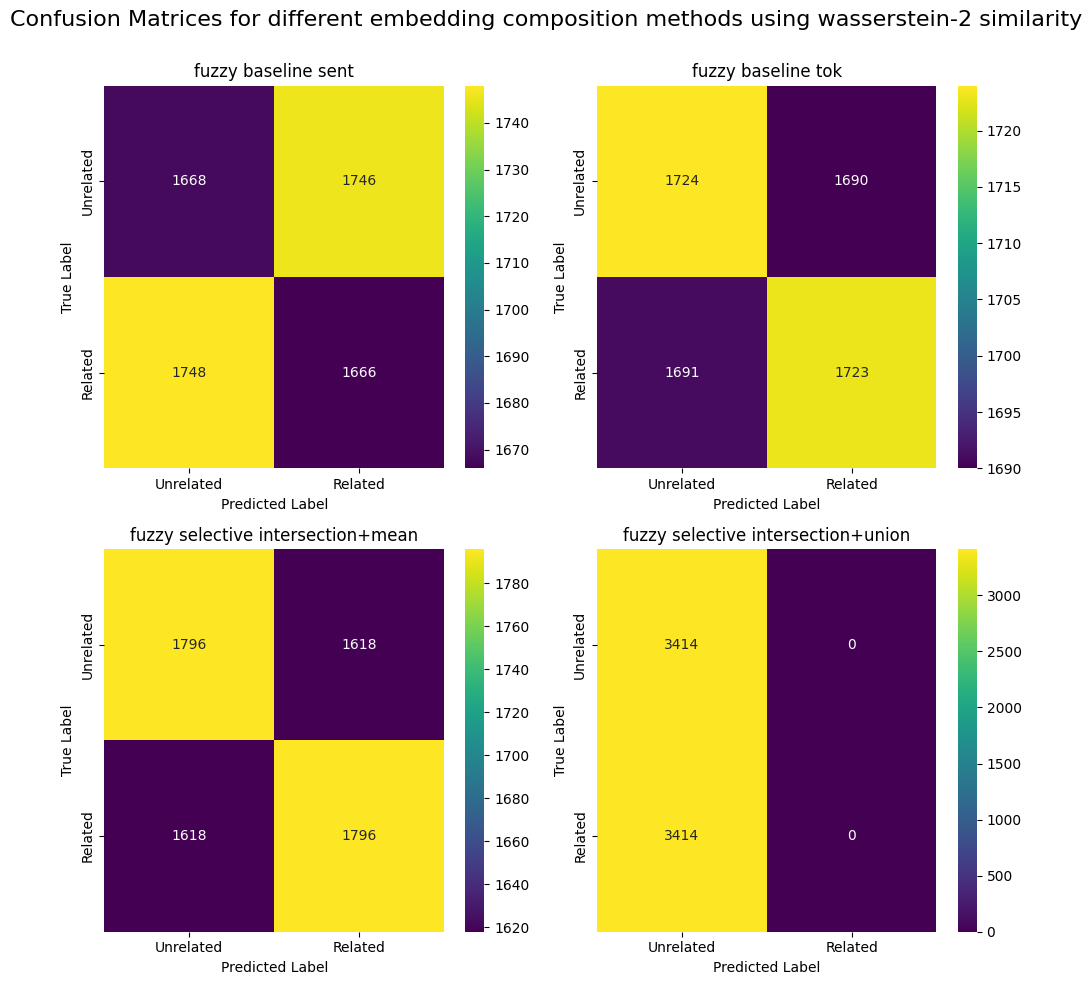

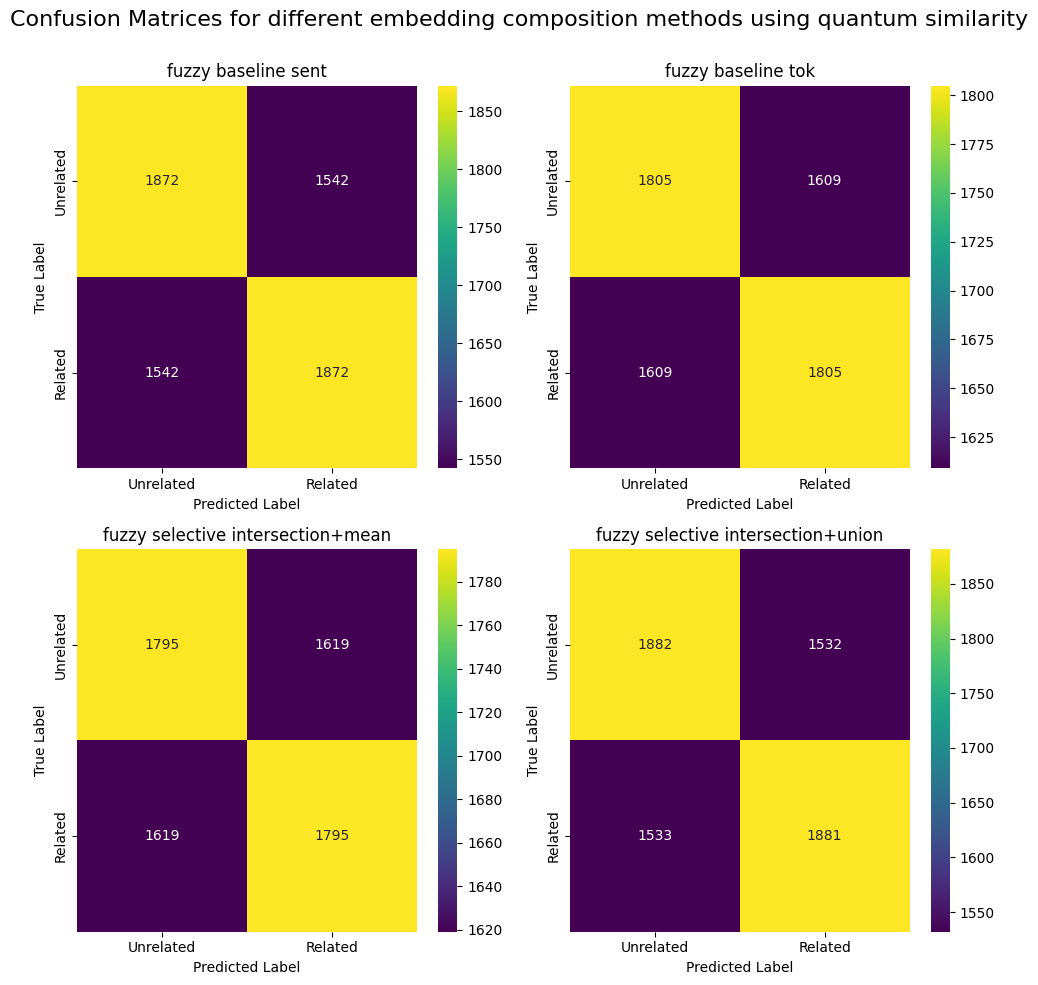

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"fuzzy_{model}_{sim_metric}_sim_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_test
)

# Evaluation Results

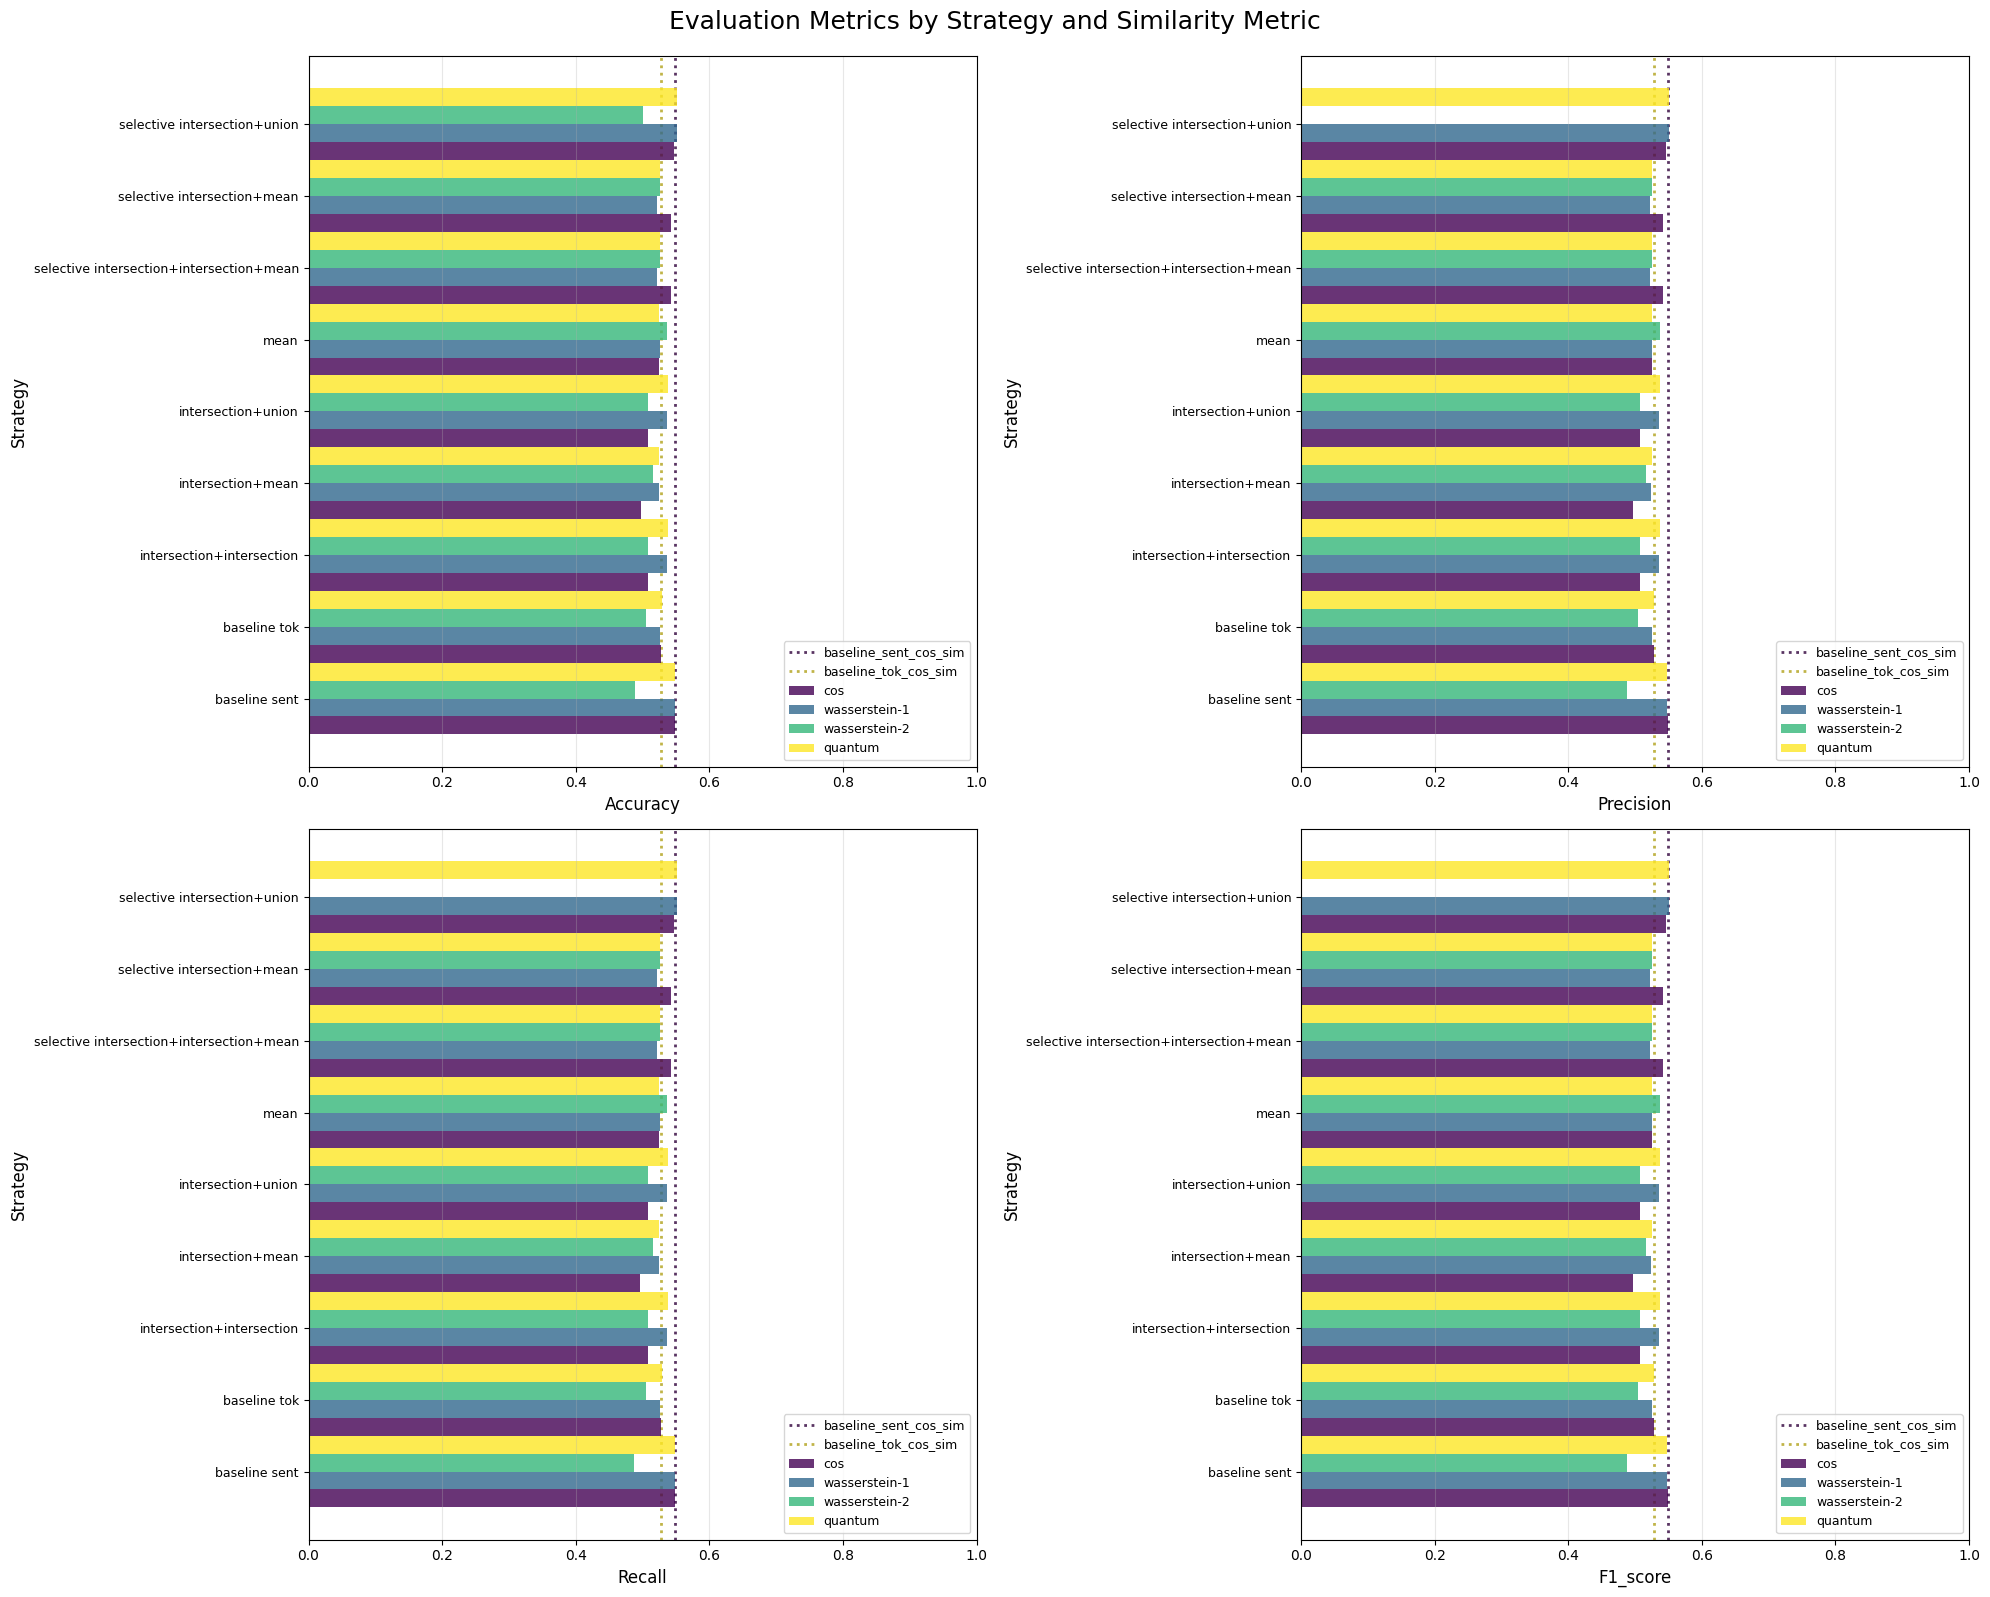

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,selective_intersection+union,wasserstein-1,fuzzy_selective_intersection+union_wasserstein...,0.551260,0.551260,0.551260,0.551260
1,selective_intersection+union,quantum,fuzzy_selective_intersection+union_quantum_sim,0.551113,0.551128,0.550967,0.551047
2,baseline_sent,cos,baseline_sent_cos_sim,0.549209,0.549209,0.549209,0.549209
3,baseline_sent,wasserstein-1,fuzzy_baseline_sent_wasserstein-1_sim,0.548623,0.548623,0.548623,0.548623
4,baseline_sent,quantum,fuzzy_baseline_sent_quantum_sim,0.548330,0.548330,0.548330,0.548330
5,selective_intersection+union,cos,fuzzy_selective_intersection+union_cos_sim,0.546866,0.546866,0.546866,0.546866
6,baseline_sent,cos,fuzzy_baseline_sent_cos_sim,0.543644,0.543644,0.543644,0.543644
7,selective_intersection+intersection+mean,cos,fuzzy_selective_intersection+intersection+mean...,0.542179,0.542179,0.542179,0.542179
8,selective_intersection+mean,cos,fuzzy_selective_intersection+mean_cos_sim,0.542179,0.542179,0.542179,0.542179
9,intersection+intersection,quantum,fuzzy_intersection+intersection_quantum_sim,0.538079,0.538079,0.538079,0.538079


In [10]:
metrics_df = eval_harness.score(sim_eval_df, y_test)
metrics_df[:10]

In [12]:
metrics_df.to_csv(f"full_eval-wn_enriched={enrich_lemmas_with_wn}-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")